In [2]:
from google.colab import drive

# Mount Google Drive to access saved model and data
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pandas as pd
import joblib

# Correct model and test dataset paths
model_path = '/content/drive/MyDrive/IDS data sets/DT_Model.joblib'  # model path
test_data_path = '/content/drive/MyDrive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv'  # test data path
train_data_path = '/content/drive/MyDrive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_train.csv'  # train data path


# Load the model using joblib
DT_Model = joblib.load(model_path)

# Load the test dataset
test_data = pd.read_csv(test_data_path)
train_data = pd.read_csv(train_data_path)

In [4]:
X_train = train_data.drop(columns=['Attack'])
y_train = train_data['Attack']

X_test = test_data.drop(columns=['Attack'])
y_test = test_data['Attack']

In [5]:
# Get the feature names used during training
training_features = DT_Model.feature_names_in_

# Select only the common features from the test data
X_test = X_test[training_features]

# Now, make predictions using the aligned test data
y_pred = DT_Model.predict(X_test)

# Print predictions to verify
print(f'The Prediction for index 698 is: {y_pred[698]}, and y_test is: {y_test[698]}')

The Prediction for index 698 is: DDoS, and y_test is: DDoS


Attack
DDoS              484
DoS               436
Reconnaissance     75
Benign              6
Name: count, dtype: int64


<Axes: xlabel='Attack', ylabel='count'>

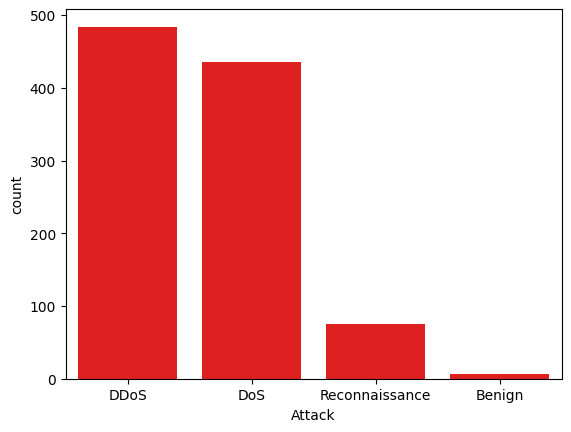

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
X = test_data.drop(['Attack'],axis= 1 )
y = test_data.loc[:, 'Attack']
print( test_data.loc[:, 'Attack'].value_counts())

sns.countplot(data=test_data,x='Attack',color='red')

In [7]:
class_names = y_train.unique()  # Get unique values from the target variable
class_names

array(['DoS', 'DDoS', 'Reconnaissance', 'Benign', 'Theft'], dtype=object)

In [ ]:
import shap

# Calculate SHAP values
explainer = shap.TreeExplainer(DT_Model,)
shap_values = explainer.shap_values(X_test)


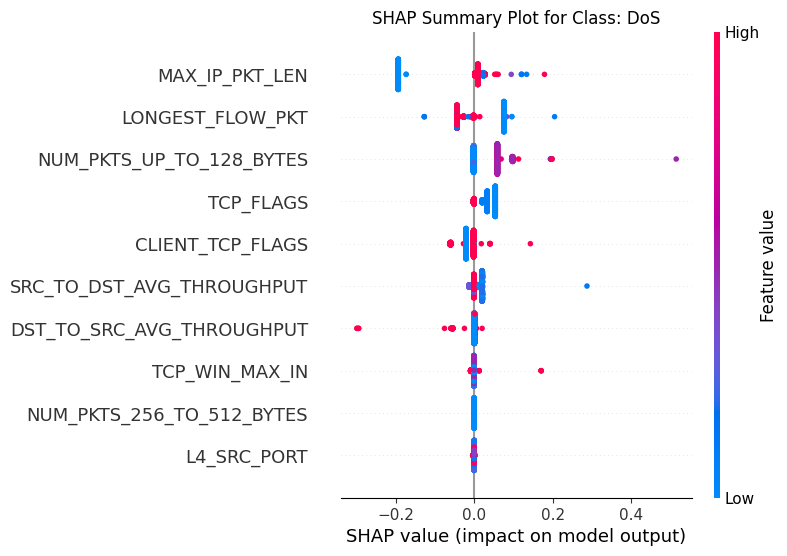

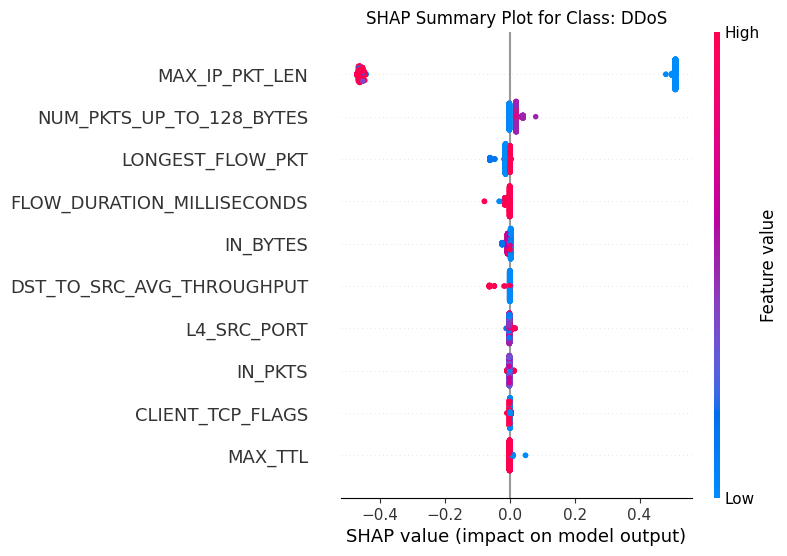

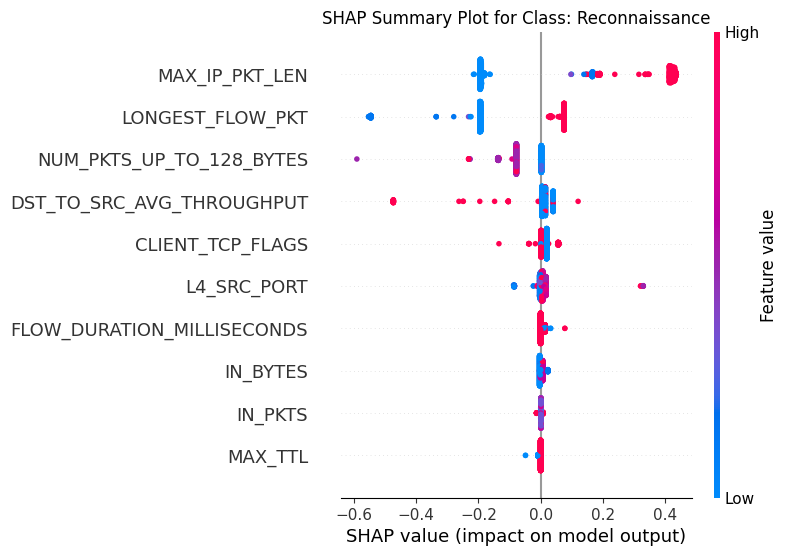

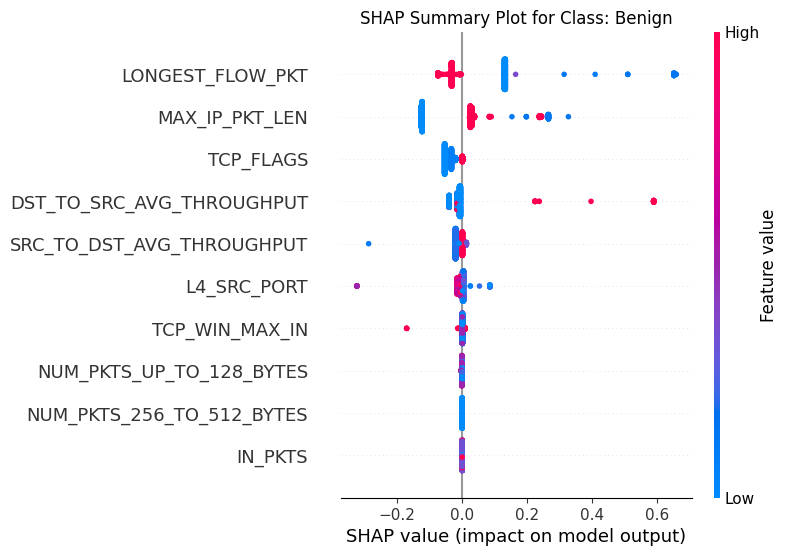

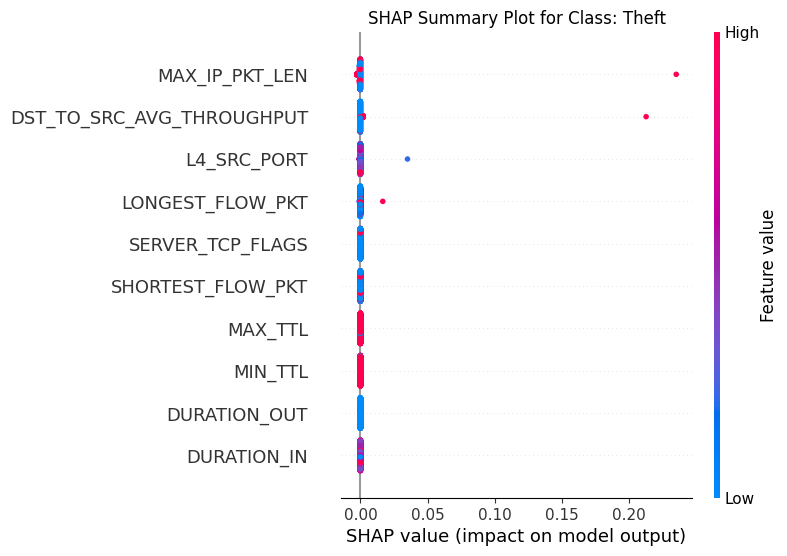

In [ ]:

# Plotting with adjusted figure size
num_classes = shap_values.shape[2]
for class_index in range(num_classes):
    shap_values_class = shap_values[:, :, class_index]

    # Set figure size before plotting
    plt.figure(figsize=(10, 6))  # Adjust width and height as needed

    shap.summary_plot(shap_values_class, X_test, feature_names=X_test.columns,
                      max_display=10, show=False)
    class_name = class_names[class_index]
    plt.title(f"SHAP Summary Plot for Class: {class_name}")


In [8]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=32698e6807bbb6a34e2bdd0ec60b177eb95102c32e211423346e0105ff1df64c
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [10]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train.values,  # Use training data for LIME
    feature_names=training_features,
    class_names=DT_Model.classes_,  # Get class names from the model
    mode="classification",
)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [11]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling (using StandardScaler as an example)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [12]:
# Convert data to Pandas DataFrame (if not already)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

In [13]:
from sklearn.feature_selection import VarianceThreshold

# Remove near-zero variance features
# You may need to adjust the threshold (e.g., 0.01, 0.05) based on your data
selector = VarianceThreshold(threshold=0.01) #from sklearn.feature_selection import VarianceThreshold !pip install scikit-learn
X_train_scaled = selector.fit_transform(X_train_scaled)
X_test_scaled = selector.transform(X_test_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_variance_threshold.py:112: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)


In [14]:
# Get the remaining feature names after VarianceThreshold
training_features = X_train.columns[selector.get_support()]

# Now create the DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=training_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=training_features, index=X_test.index)

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:

# Re-train your DecisionTreeClassifier with the selected features
DT_Model = DecisionTreeClassifier(criterion= 'gini' ,max_depth=5, max_features='sqrt', min_samples_split=10,
                       random_state=42)
DT_Model.fit(X_train_scaled, y_train)  # Assuming y_train is your target variable


DecisionTreeClassifier(max_depth=5, max_features='sqrt', min_samples_split=10,
                       random_state=42)

In [19]:
#Re-initialize the LIME explainer with scaled data, adding a small epsilon to the scale
explainer = LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=training_features,
    class_names=DT_Model.classes_,
    mode="classification",
    # Discretizer with small epsilon to avoid zero variance features
    discretize_continuous=True,
    discretizer='quartile',  # or another robust method like 'decile'
)

/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.10/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

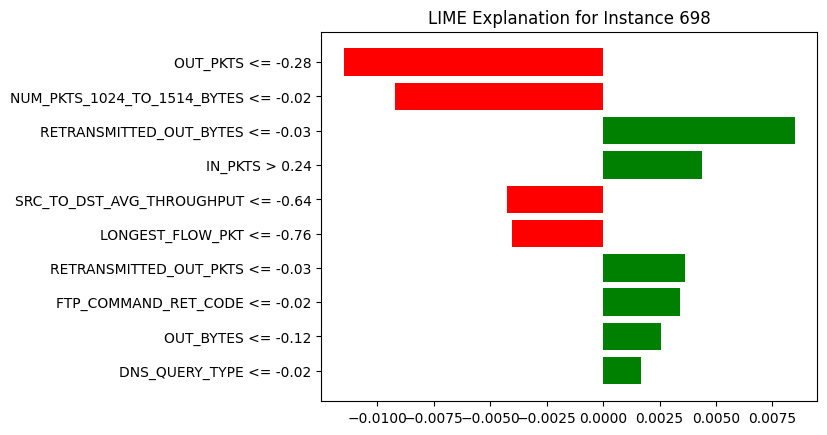

In [21]:
# Choose an instance to explain (for example, the first instance)
# Make sure to select the instance from the scaled and feature-selected test data
instance_to_explain = X_test_scaled.iloc[698]

# Generate LIME explanation
lime_exp = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=DT_Model.predict_proba
)

# Plot LIME explanation for the selected instance
lime_exp.as_pyplot_figure()
plt.title('LIME Explanation for Instance 698')
plt.show()